In [1]:
# ===============================================================
# STEP 0: MEMBUAT DATASET PASIEN (HOSPITAL CHURN)
# ===============================================================
import pandas as pd
import numpy as np
import os

# Set seed agar hasil konsisten
np.random.seed(42)

# Jumlah data
n = 1000

# Membuat dataset sintetis pasien
data = {
    "PatientID": [f"PAT{i:04d}" for i in range(1, n+1)],
    "Age": np.random.randint(18, 85, n),
    "Gender": np.random.choice(["Male", "Female"], n),
    "MaritalStatus": np.random.choice(["Single", "Married", "Divorced", "Widowed"], n),
    "VisitFrequency": np.random.randint(1, 15, n),
    "LastVisitDaysAgo": np.random.randint(1, 365, n),
    "ChronicDisease": np.random.choice(["Yes", "No"], n, p=[0.4, 0.6]),
    "TreatmentSatisfaction": np.random.randint(1, 6, n),
    "BillingIssues": np.random.choice(["Yes", "No"], n, p=[0.2, 0.8]),
    "InsuranceType": np.random.choice(["Private", "Government", "None"], n, p=[0.5, 0.3, 0.2]),
    "TotalSpent": np.random.uniform(200, 10000, n).round(2)
}

# Membuat DataFrame
df_hospital = pd.DataFrame(data)

# Membuat label churn (berdasarkan logika realistis)
# Pasien yang lama tidak datang (>180 hari) atau kepuasan <3 lebih cenderung churn
df_hospital["Churn"] = np.where(
    (df_hospital["LastVisitDaysAgo"] > 180) | (df_hospital["TreatmentSatisfaction"] < 3),
    1, 0
)

# Simpan ke folder Data/raw/
os.makedirs("../Data/raw", exist_ok=True)
file_path = "../Data/raw/hospital_churn_raw.csv"
df_hospital.to_csv(file_path, index=False)

print(f"✅ Dataset pasien berhasil dibuat dan disimpan di: {file_path}")
print(f"Jumlah data: {df_hospital.shape}")
df_hospital.head()


✅ Dataset pasien berhasil dibuat dan disimpan di: ../Data/raw/hospital_churn_raw.csv
Jumlah data: (1000, 12)


,PatientID,Age,Gender,MaritalStatus,VisitFrequency,LastVisitDaysAgo,ChronicDisease,TreatmentSatisfaction,BillingIssues,InsuranceType,TotalSpent,Churn
0,PAT0001,69,Male,Single,12,219,No,4,No,Private,3587.08,1
1,PAT0002,32,Female,Widowed,12,82,No,3,No,Private,6290.77,0
2,PAT0003,78,Female,Widowed,3,92,Yes,3,No,Government,580.23,0
3,PAT0004,38,Female,Married,1,175,Yes,3,No,Private,2030.37,0
4,PAT0005,41,Male,Married,14,239,No,5,No,None,8346.21,1


In [2]:
# ===============================================================
# STEP 0: SETUP & LOAD DATA
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os, warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# Path file dataset
file_path = "../Data/raw/hospital_churn_raw.csv"

# Cek file
if not os.path.exists(file_path):
    raise FileNotFoundError(f"❌ File '{file_path}' tidak ditemukan!")

# Load dataset
df = pd.read_csv(file_path)
print("✅ Dataset berhasil dibaca!")
print(f"Ukuran data: {df.shape}")
display(df.head())


✅ Dataset berhasil dibaca!
Ukuran data: (1000, 12)


,PatientID,Age,Gender,MaritalStatus,VisitFrequency,LastVisitDaysAgo,ChronicDisease,TreatmentSatisfaction,BillingIssues,InsuranceType,TotalSpent,Churn
0,PAT0001,69,Male,Single,12,219,No,4,No,Private,3587.08,1
1,PAT0002,32,Female,Widowed,12,82,No,3,No,Private,6290.77,0
2,PAT0003,78,Female,Widowed,3,92,Yes,3,No,Government,580.23,0
3,PAT0004,38,Female,Married,1,175,Yes,3,No,Private,2030.37,0
4,PAT0005,41,Male,Married,14,239,No,5,No,NaN,8346.21,1


In [3]:
# ===============================================================
# STEP 1: DATA OVERVIEW
# ===============================================================

print("📋 Informasi Umum Dataset:")
df.info()

print("\n📊 Statistik Deskriptif:")
display(df.describe(include="all").T)

print("\n🧩 Missing Values:")
print(df.isnull().sum())

print("\n🔁 Duplikat:", df.duplicated().sum())


📋 Informasi Umum Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientID              1000 non-null   object 
 1   Age                    1000 non-null   int64  
 2   Gender                 1000 non-null   object 
 3   MaritalStatus          1000 non-null   object 
 4   VisitFrequency         1000 non-null   int64  
 5   LastVisitDaysAgo       1000 non-null   int64  
 6   ChronicDisease         1000 non-null   object 
 7   TreatmentSatisfaction  1000 non-null   int64  
 8   BillingIssues          1000 non-null   object 
 9   InsuranceType          793 non-null    object 
 10  TotalSpent             1000 non-null   float64
 11  Churn                  1000 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 93.9+ KB

📊 Statistik Deskriptif:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PatientID,1000,1000,PAT0001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1000.0,NaN,NaN,NaN,50.676,19.7803,18.0,34.0,50.0,68.0,84.0
Gender,1000,2,Male,505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MaritalStatus,1000,4,Married,262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VisitFrequency,1000.0,NaN,NaN,NaN,7.465,4.051072,1.0,4.0,7.0,11.0,14.0
LastVisitDaysAgo,1000.0,NaN,NaN,NaN,179.927,106.263717,1.0,88.0,175.0,274.0,364.0
ChronicDisease,1000,2,No,586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TreatmentSatisfaction,1000.0,NaN,NaN,NaN,2.95,1.41262,1.0,2.0,3.0,4.0,5.0
BillingIssues,1000,2,No,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InsuranceType,793,2,Private,517,NaN,NaN,NaN,NaN,NaN,NaN,NaN



🧩 Missing Values:
PatientID                  0
Age                        0
Gender                     0
MaritalStatus              0
VisitFrequency             0
LastVisitDaysAgo           0
ChronicDisease             0
TreatmentSatisfaction      0
BillingIssues              0
InsuranceType            207
TotalSpent                 0
Churn                      0
dtype: int64

🔁 Duplikat: 0


In [4]:
# ===============================================================
# STEP 2: DATA CLEANING
# ===============================================================

# Hapus duplikat
df.drop_duplicates(inplace=True)

# Tangani missing values (jika ada)
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Pastikan kolom target bertipe int
df["Churn"] = df["Churn"].astype(int)

print("✅ Data cleaning selesai!")
display(df.head())


✅ Data cleaning selesai!


,PatientID,Age,Gender,MaritalStatus,VisitFrequency,LastVisitDaysAgo,ChronicDisease,TreatmentSatisfaction,BillingIssues,InsuranceType,TotalSpent,Churn
0,PAT0001,69,Male,Single,12,219,No,4,No,Private,3587.08,1
1,PAT0002,32,Female,Widowed,12,82,No,3,No,Private,6290.77,0
2,PAT0003,78,Female,Widowed,3,92,Yes,3,No,Government,580.23,0
3,PAT0004,38,Female,Married,1,175,Yes,3,No,Private,2030.37,0
4,PAT0005,41,Male,Married,14,239,No,5,No,Private,8346.21,1


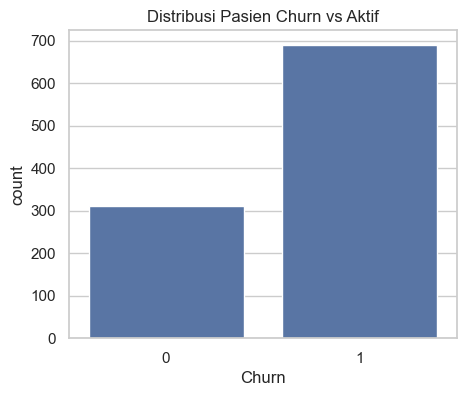

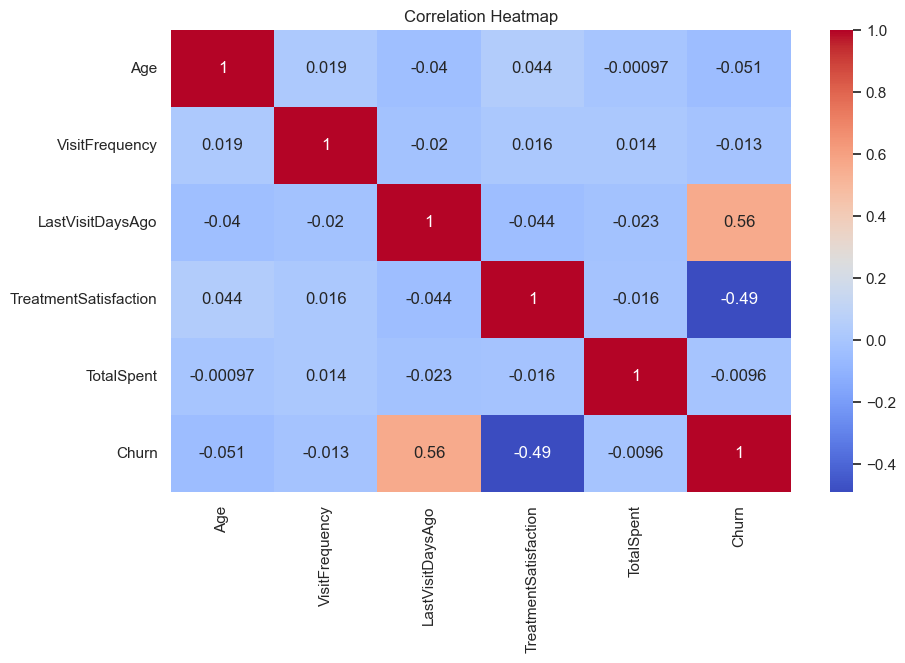

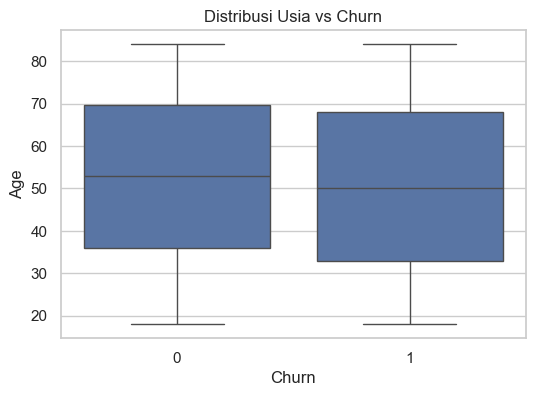

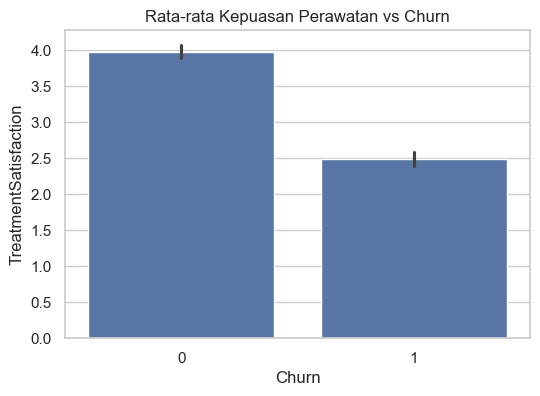

In [5]:
# ===============================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ===============================================================

# Distribusi churn
plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df)
plt.title("Distribusi Pasien Churn vs Aktif")
plt.show()

# Korelasi numerik
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Distribusi usia berdasarkan churn
plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="Age", data=df)
plt.title("Distribusi Usia vs Churn")
plt.show()

# Rata-rata kepuasan berdasarkan churn
plt.figure(figsize=(6,4))
sns.barplot(x="Churn", y="TreatmentSatisfaction", data=df)
plt.title("Rata-rata Kepuasan Perawatan vs Churn")
plt.show()


In [9]:
# ===============================================================
# STEP 4: FEATURE ENGINEERING (ENCODING & SCALING)
# ===============================================================

from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns

# Label encoding
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("✅ Encoding selesai!")

# Scaling hanya untuk fitur numerik (tidak termasuk 'Churn')
scaler = StandardScaler()
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop("Churn", errors='ignore')
df[num_cols] = scaler.fit_transform(df[num_cols])

print("✅ Scaling selesai tanpa mengubah kolom target!")
display(df.head())


✅ Encoding selesai!
✅ Scaling selesai tanpa mengubah kolom target!


,PatientID,Age,Gender,MaritalStatus,VisitFrequency,LastVisitDaysAgo,ChronicDisease,TreatmentSatisfaction,BillingIssues,InsuranceType,TotalSpent,Churn
0,-1.730320,0.926840,0.990050,0.407946,1.120017,0.367882,-0.840526,0.743672,-0.5,0.617426,-0.480898,0.670280
1,-1.726856,-0.944644,-1.010051,1.316512,1.120017,-0.922008,-0.840526,0.035413,-0.5,0.617426,0.489615,-1.491914
2,-1.723391,1.382066,-1.010051,1.316512,-1.102729,-0.827855,1.189731,0.035413,-0.5,-1.619626,-1.560234,-1.491914
3,-1.719927,-0.641160,-1.010051,-0.500620,-1.596672,-0.046389,1.189731,0.035413,-0.5,0.617426,-1.039693,-1.491914
4,-1.716463,-0.489418,0.990050,-0.500620,1.613960,0.556188,-0.840526,1.451930,-0.5,0.617426,1.227434,0.670280


In [10]:
# ===============================================================
# STEP 5: SPLIT DATA
# ===============================================================
df["Churn"] = df["Churn"].astype(int)

y_train = y_train.astype(int)
y_test = y_test.astype(int)


🎯 Random Forest Performance
Accuracy: 1.0

Confusion Matrix:
 [[ 62   0]
 [  0 138]]

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        62
           0       1.00      1.00      1.00       138

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



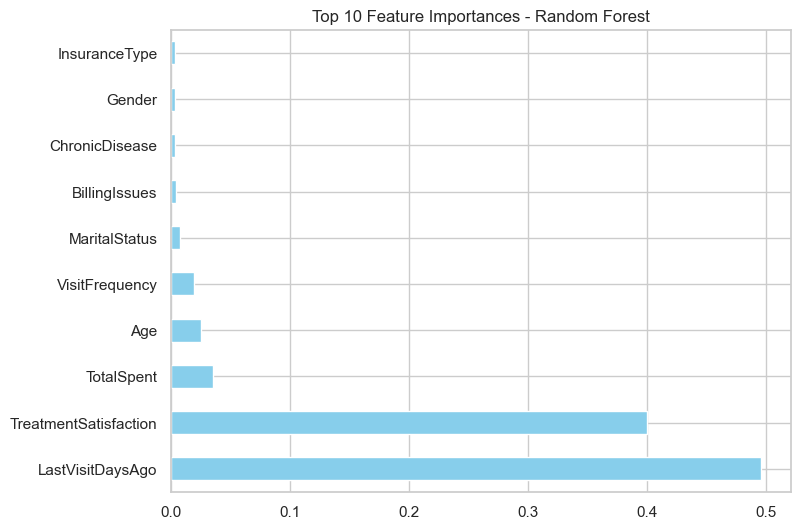

In [11]:
# ===============================================================
# STEP 6A: MODELING (RANDOM FOREST)
# ===============================================================

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("🎯 Random Forest Performance")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Feature importance
plt.figure(figsize=(8,6))
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind="barh", color='skyblue')
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()


In [12]:
# ===============================================================
# STEP 6B: MODELING (LOGISTIC REGRESSION)
# ===============================================================

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

print("🎯 Logistic Regression Performance")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


🎯 Logistic Regression Performance
Accuracy: 0.905

Confusion Matrix:
 [[ 51  11]
 [  8 130]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.82      0.84        62
           0       0.92      0.94      0.93       138

    accuracy                           0.91       200
   macro avg       0.89      0.88      0.89       200
weighted avg       0.90      0.91      0.90       200



In [13]:
# ===============================================================
# STEP 7: SAVE CLEANED DATASET
# ===============================================================

output_dir = "../Data/cleaned"
os.makedirs(output_dir, exist_ok=True)

clean_path = os.path.join(output_dir, "hospital_churn_cleaned.csv")
df.to_csv(clean_path, index=False)

print(f"💾 Dataset cleaned disimpan di: {clean_path}")


💾 Dataset cleaned disimpan di: ../Data/cleaned\hospital_churn_cleaned.csv


In [14]:
import joblib
os.makedirs("../Outputs", exist_ok=True)

joblib.dump(rf_model, "../Outputs/hospital_rf_model.pkl")
joblib.dump(log_model, "../Outputs/hospital_log_model.pkl")

print("🤖 Model berhasil disimpan ke folder Outputs!")


🤖 Model berhasil disimpan ke folder Outputs!
